In [28]:
#Causal eSTRs Enrichment
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from collections import defaultdict

ANNOTDIR = "/storage/mgymrek/gtex/annotations/"
FEATUREDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
HTDIR = "/storage/mgymrek/gtex/tfbs/encodedata/"
BEDDIR = "/storage/mgymrek/gtex/annotations/encode/"
mergefile = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table'
REGRSSION = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
SCORETYPE = ""
MINDIST = 1500 # For TSS

# Output path
OUTPATH = "pdfs"
PREFIX = "Figure2" # Keep as a variable in case we move things around!

# LIst of features to intersect with
"""
FEATURES = {
    "B_introns": os.path.join(ANNOTDIR, "introns.bed"),
    "C_3utr": os.path.join(ANNOTDIR, "3utr.bed"),
    "D_5utr": os.path.join(ANNOTDIR, "5utr.bed"),
    "E_promoter_1kb": os.path.join(ANNOTDIR, "hg19_promoter_1kb.bed"),
    "F_H3K4me1": os.path.join(HTDIR, "H3K4me1_GM12878.bed.gz"),
    "G_H3K4me2": os.path.join(HTDIR, "H3K4me2_GM12878.bed.gz"),
    "H_H3K4me3": os.path.join(HTDIR, "H3K4me3_GM12878.bed.gz"),
    "I_H3K27ac": os.path.join(HTDIR, "H3K27ac_GM12878.bed.gz"),
    "J_H3K27me3": os.path.join(HTDIR, "H3K27me3_GM12878.bed.gz"),
    "K_H3K36me3": os.path.join(HTDIR, "H3K36me3_GM12878.bed.gz") 
}
"""
letters = ["A","B","C","D","E","F","G","H","I","J","K","L","M"]
i = 0
FEATURES = {}
for state in ["Active_Promoter","Weak_Promoter","Strong_Enhancer","Weak_Enhancer","Txn_Elongation","Txn_Transition","Weak_Txn","Heterochrom","Repressed"]:
    FEATURES[letters[i]+"_"+state] = os.path.join(BEDDIR,"%s_GM12878.bed"%state)
    i+= 1
#    "A_coding": os.path.join(ANNOTDIR, "coding.bed"),


Populating the interactive namespace from numpy and matplotlib


In [ ]:
command="cat %s/LR_SummaryTest_Table.tsv | awk '$76==1'| cut -f 1,2,75 > homopolymers.tab "%(FEATUREDIR,)
return_values=os.system(command)

In [ ]:
%%bash
# Get all STRs analyzed
BASEDIR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue
TISSUES=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/list_tissues
for t in $(cat $TISSUES)
do
    cat ${BASEDIR}/${t}/Lin_Reg_Out | grep -v gene | awk '{print $2 "\t" $4 "\t" $4+1}'
done | sort | uniq > all_analyzed_strs.bed

In [29]:
# Get features on all STRs analyzed - TODO update when we have all loci

all_strs = pd.read_csv("all_analyzed_strs.bed", sep="\t", names=["chrom","start","end"])
#all_strs = pd.read_csv("homopolymers.tab", sep="\t", names=["chrom","start","end"])

all_strs["locus"] = all_strs.apply(lambda x: x["chrom"]+":"+str(x["start"]), 1)
for key in FEATURES.keys():
    bedfile = FEATURES[key]
    cmd = "bedtools intersect -a all_analyzed_strs.bed -b %s > Intersect.bed"%bedfile
    returned_value = os.system(cmd)
    Inter = pd.read_csv('Intersect.bed', sep='\t', names=["chrom","start","end"])
    feature_loci = set(Inter.apply(lambda x: x["chrom"]+":"+str(x["start"]), 1))
    all_strs[key] = np.where(all_strs["locus"].isin(feature_loci), 1, 0)
Inter.head(5)

,chrom,start,end
0,chr10,100203797,100203798
1,chr10,104533609,104533610
2,chr10,112334451,112334452
3,chr10,11588568,11588569
4,chr10,121076860,121076861


In [30]:
# Get data on best STR per gene
data = pd.read_csv(mergefile, sep='\t')
data['str.start']=data['best.str.start']
GG   = pd.read_csv(REGRSSION, sep='\t')
data_best = pd.merge(data, GG[['chrom','str.start', 'gene','str.end','motif','E.tissues','period']], on=['chrom', 'str.start','gene' ])


#data_best = data_best.loc[data_best['period']==1].copy()   #Homopolymers

In [31]:
SCORE_THRESHOLD = 0.1 # causality score threshold
MINQ = 0.1 # FDR threshold for eSTR

data_best["is.estr"] = (data_best["best.q"]<=MINQ)
data_best["is.causal"] = data_best.apply(lambda x: "SNP" not in x["top.variant"] , 1) #and x["best.score"]>=SCORE_THRESHOLD, 1)
data_best["is.not.causal"]= data_best.apply(lambda x: "SNP" in x["top.variant"] and x["best.q"]<=MINQ, 1)

# Add features
data_best["start"] = data_best["best.str.start"]
data_best = pd.merge(data_best, all_strs)
#print(data_best.shape,GG.shape ,data.shape)  #(11810, 31) (307187, 77) (11869, 11) if merger with inner

In [32]:
OR_estr_vs_all = []
P_estr_vs_all = []

OR_causal_all = []
P_causal_all = []

OR_noncausal_all = []
P_noncausal_all = []


keys = list(FEATURES.keys())

num_total_strs = all_strs.shape[0]
num_total_e_strs = sum(data_best["is.estr"])
num_total_causal = sum(data_best["is.causal"])
num_total_noncausal = sum(data_best["is.not.causal"])
print(num_total_strs,'\t estrs:',num_total_e_strs,'  causal:',num_total_causal,'  notcausal:',num_total_noncausal)

def NormTable(table, total):
    table[1][1] = total-sum(table)
    return table

for key in keys:
    num_total_feature = sum(all_strs[key])
    num_e_feature = sum(data_best[data_best["is.estr"]][key])
    num_causal_feature = sum(data_best[data_best["is.causal"]][key])
    num_noncausal_feature = sum(data_best[data_best["is.not.causal"]][key])
    ##print(key,' in all STRs: ',num_total_feature )
    ##print('Feauture-estrs:',num_e_feature, '  Feature-causal:',num_causal_feature,'  Feature-noncausal:',num_noncausal_feature)    
    # eSTRs vs. non eSTRs 
    # [estr_feature, estr_nofeature]
    # [noestr_feature, none]
    table1 = [[num_e_feature, num_total_e_strs-num_e_feature],
            [num_total_feature-num_e_feature, 0]]
    
    table1 = NormTable(table1, num_total_strs)
    OR, p = ss.fisher_exact(table1)
    OR_estr_vs_all.append(OR)
    P_estr_vs_all.append(p)
    ##print('\nestrs',table1)

    # causalestr vs. all
    # [causalestr_feature, causalestr_nofeature]
    # [nocausalestr_feature, none]
    table4 = [[num_causal_feature, num_total_causal - num_causal_feature],
            [num_total_feature-num_causal_feature, 0]]
    table4 = NormTable(table4, num_total_strs)
    OR, p = ss.fisher_exact(table4)
    OR_causal_all.append(OR)
    P_causal_all.append(p)
    ##print('\ncausal',table4)
    
    # Noncausalestr vs. all
    # [noncausalestr_feature, noncausalestr_nofeature]
    # [otherstr_feature, none]
    table5 = [[num_noncausal_feature, num_total_noncausal - num_noncausal_feature],
            [num_total_feature-num_noncausal_feature, 0]]
    table5 = NormTable(table5, num_total_strs)
    OR, p = ss.fisher_exact(table5)
    OR_noncausal_all.append(OR)
    P_noncausal_all.append(p)
    ##print('\nnon causal',table5)

        
enrich_table = pd.DataFrame({
    "feature": keys,
    "OR_estr_all": OR_estr_vs_all,
    "P_estr_all": P_estr_vs_all,
    "OR_noncausal_all": OR_noncausal_all,
    "P_noncausal_all": P_noncausal_all,
    "OR_causal_all": OR_causal_all,
    "P_causal_all": P_causal_all
})
enrich_table = enrich_table[["feature", "OR_estr_all","P_estr_all","OR_noncausal_all","P_noncausal_all",
                            "OR_causal_all","P_causal_all"]]

enrich_table['fold'] = 
enrich_table.sort_values("feature")

125758 	 estrs: 11810   causal: 4482   notcausal: 7328


,feature,OR_estr_all,P_estr_all,OR_noncausal_all,P_noncausal_all,OR_causal_all,P_causal_all
4,A_Active_Promoter,3.157483,4.104658e-45,2.598741,1.112800e-20,3.289643,8.048385e-24
0,B_Weak_Promoter,2.976406,8.134387e-39,2.772750,1.535297e-23,2.660803,2.066220e-14
6,C_Strong_Enhancer,1.489253,1.002845e-10,1.399286,1.407465e-05,1.546557,3.567259e-06
2,D_Weak_Enhancer,1.603164,2.914973e-28,1.616253,6.093677e-20,1.473829,9.034119e-09
5,E_Txn_Elongation,2.337511,5.350374e-156,1.995648,4.897477e-66,2.555569,7.410229e-87
8,F_Txn_Transition,2.194578,5.583964e-20,2.071673,6.143106e-12,2.091894,2.066449e-08
3,G_Weak_Txn,1.680700,1.263100e-96,1.585849,6.220635e-50,1.709156,3.956612e-44
7,H_Heterochrom,0.402755,0.000000e+00,0.450125,3.164552e-237,0.379593,3.701458e-219
1,I_Repressed,1.077227,1.247630e-01,1.084723,1.748830e-01,1.055365,4.830436e-01


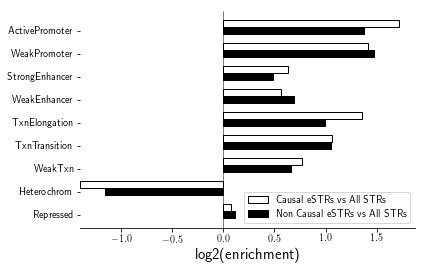

In [33]:
#Chromatin states
#Plot (OR_estr_all, OR_causal_all)
enrich_table = enrich_table.sort_values("feature", ascending=False)

w = 0.3
fig = plt.figure()
ax = fig.add_subplot(111)
yvals = np.array(range(len(keys)))
bars1 = ax.barh(yvals+w, np.log2(enrich_table["OR_causal_all"]), height=w, color="white", label='Causal eSTRs vs All STRs', edgecolor="black")
bars2 = ax.barh(yvals, np.log2(enrich_table["OR_noncausal_all"]), height=w, color="black", label='Non Causal eSTRs vs All STRs', edgecolor="black")
ax.axvline(x=0, color="black", linewidth=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(loc='lower right', fontsize=10)
ax.set_yticks(yvals)
ax.set_yticklabels([item[2:].replace("_","") for item in enrich_table["feature"]]);
ax.set_xlabel("log2(enrichment)", size=15);
fig.savefig(os.path.join(OUTPATH, "%s_causality_enrichment_chromatins.pdf"%PREFIX))

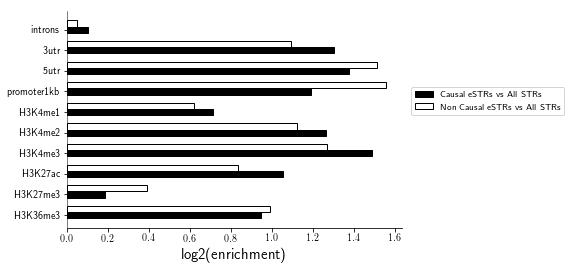

In [27]:
#Histone modification
# Plot (OR_estr_all, OR_causal_all)
enrich_table = enrich_table.sort_values("feature", ascending=False)
OUTPATH = "pdfs"
w = 0.3
fig = plt.figure()
ax = fig.add_subplot(111)
yvals = np.array(range(len(keys)))
bars1 = ax.barh(yvals, np.log2(enrich_table["OR_causal_all"]), height=w, color="black", label='Causal eSTRs vs All STRs', edgecolor="black")
bars2 = ax.barh(yvals+w, np.log2(enrich_table["OR_noncausal_all"]), height=w, color="white", label='Non Causal eSTRs vs All STRs', edgecolor="black")
ax.axvline(x=0, color="black", linewidth=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(loc='lower right', fontsize=9, bbox_to_anchor=(1.5, 0.5))
ax.set_yticks(yvals)
ax.set_yticklabels([item[2:].replace("_","") for item in enrich_table["feature"]]);
ax.set_xlabel("log2(enrichment)", size=15);
fig.savefig(os.path.join(OUTPATH, "%s_causality_enrichment_histones.pdf"%PREFIX))